In [1]:
NUMBER_OF_SAMPLES = 1_000_000 # 1_000_000
DATA_RATIOS = [0.8, 0.9] # train, valid, test

In [2]:
!conda create -y --name nyc

Solving environment: done

## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/nyc


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
#
# To activate this environment, use
#
#     $ conda activate nyc
#
# To deactivate an active environment, use
#
#     $ conda deactivate



In [3]:
!sudo ln -s /home/ec2-user/anaconda3/etc/profile.d/conda.sh /etc/profile.d/conda.sh
!conda activate
!conda activate nyc
!conda env list


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
If your shell is Bash or a Bourne variant, enable conda for the current user with

    $ echo ". /home/ec2-user/anaconda3/etc/profile.d/conda.sh" >> ~/.bashrc

or, for all users, enable conda with

    $ sudo ln -s /home/ec2-user/anaconda3/etc/profile.d/conda.sh /etc/profile.d/conda.sh

The options above will permanently enable the 'conda' command, but they do NOT
put conda's base (root) environment on PATH.  To do so, run

    $ conda activate

in your terminal, or to put the base environment on PATH permanently, run

    $ echo "conda activate" >> ~/.bashrc

Previous to conda 4.4, the recommended way to activate conda was to modify PATH in
your ~/.bashrc file.  You should manually remove the line that looks like

    export PATH="/home/ec2-user/anaconda3/bin:$PATH"

^^^ The above line should NO LONGER be in your ~/.bashrc file! ^^^



CommandNotFoundError: Your shell has not been properly conf

In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [5]:
!pip install pyathena

    100% |████████████████████████████████| 51kB 2.2MB/s ta 0:00:01
    100% |████████████████████████████████| 829kB 7.3MB/s ta 0:00:01
  Running setup.py bdist_wheel for future ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built future
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
%%time
from pyathena import connect

from pyathena.pandas_cursor import PandasCursor

cursor = connect(s3_staging_dir='s3://mkamp-fastai/staging/',
                 region_name='eu-west-1',
                 cursor_class=PandasCursor).cursor()

df_raw = cursor.execute("SELECT * FROM prepared_medium.details LIMIT 100000").as_pandas()


CPU times: user 490 ms, sys: 84.9 ms, total: 574 ms
Wall time: 12 s


In [7]:
import pandas as pd

# https://github.com/fastai/fastai
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [8]:
%%time
df_raw = cursor.execute("""
SELECT 
  pu_year,
  COUNT(*)
FROM prepared_medium.details 
GROUP BY 1 
ORDER BY 1 DESC
""").as_pandas()
print(df_raw.describe())
print(df_raw.head())
display(df_raw)

           pu_year         _col1
count    11.000000  1.100000e+01
mean   2015.818182  1.138523e+07
std      16.594084  3.776042e+07
min    2001.000000  1.000000e+00
25%    2005.500000  2.000000e+00
50%    2010.000000  5.000000e+00
75%    2017.500000  6.650000e+01
max    2053.000000  1.252372e+08
   pu_year      _col1
0     2053          1
1     2041          1
2     2018        180
3     2017  125237176
4     2012          3


,pu_year,_col1
0,2053,1
1,2041,1
2,2018,180
3,2017,125237176
4,2012,3
5,2010,38
6,2009,91
7,2008,42
8,2003,5
9,2002,1


CPU times: user 43.9 ms, sys: 4.25 ms, total: 48.1 ms
Wall time: 3.32 s


In [9]:
%%time
print(df_raw.describe())
print(df_raw.head())
display(df_raw)

           pu_year         _col1
count    11.000000  1.100000e+01
mean   2015.818182  1.138523e+07
std      16.594084  3.776042e+07
min    2001.000000  1.000000e+00
25%    2005.500000  2.000000e+00
50%    2010.000000  5.000000e+00
75%    2017.500000  6.650000e+01
max    2053.000000  1.252372e+08
   pu_year      _col1
0     2053          1
1     2041          1
2     2018        180
3     2017  125237176
4     2012          3


,pu_year,_col1
0,2053,1
1,2041,1
2,2018,180
3,2017,125237176
4,2012,3
5,2010,38
6,2009,91
7,2008,42
8,2003,5
9,2002,1


CPU times: user 14.9 ms, sys: 0 ns, total: 14.9 ms
Wall time: 13.5 ms


How come there are negative trip_durations and distances?

In [10]:
%%time
limit = 3 # limits the number of records per category
flds = ['trip_duration_s', 'trip_distance', 'fare_amount']
operators = [('no', '='), ('neg', '<')]

with_expressions = []
union_expressions = []
for fld in flds:
    for (name, op) in operators:
        with_expressions += [f'''    
    {name}_{fld} AS
      (SELECT '{name}_{fld}' op, *           
       FROM prepared_medium.details TABLESAMPLE BERNOULLI(100) 
       WHERE {fld} {op} 0 LIMIT {limit}
          )''' ]
        union_expressions += [f'''SELECT * FROM {name}_{fld}
''']
    
sql = 'WITH'   
sql += ','.join(with_expressions)+'\n'
sql += 'UNION ALL\n'.join(union_expressions) 
sql += 'ORDER BY 1'
print(sql)


df_tmp = cursor.execute(sql).as_pandas()
display_all(df_tmp)
print(df_tmp.describe())

WITH    
    no_trip_duration_s AS
      (SELECT 'no_trip_duration_s' op, *           
       FROM prepared_medium.details TABLESAMPLE BERNOULLI(100) 
       WHERE trip_duration_s = 0 LIMIT 3
          ),    
    neg_trip_duration_s AS
      (SELECT 'neg_trip_duration_s' op, *           
       FROM prepared_medium.details TABLESAMPLE BERNOULLI(100) 
       WHERE trip_duration_s < 0 LIMIT 3
          ),    
    no_trip_distance AS
      (SELECT 'no_trip_distance' op, *           
       FROM prepared_medium.details TABLESAMPLE BERNOULLI(100) 
       WHERE trip_distance = 0 LIMIT 3
          ),    
    neg_trip_distance AS
      (SELECT 'neg_trip_distance' op, *           
       FROM prepared_medium.details TABLESAMPLE BERNOULLI(100) 
       WHERE trip_distance < 0 LIMIT 3
          ),    
    no_fare_amount AS
      (SELECT 'no_fare_amount' op, *           
       FROM prepared_medium.details TABLESAMPLE BERNOULLI(100) 
       WHERE fare_amount = 0 LIMIT 3
          ),    
    neg_far

,op,source,pu_year,pu_month,pu_day,pu_hour,pu_borough,pu_zone,do_borough,do_zone,trip_duration_s,fare_amount,trip_distance
0,neg_fare_amount,yellow,2017,3,19,21,Unknown,NV,Queens,"""Queens Village""",5,-2.5,0.00
1,neg_fare_amount,yellow,2017,5,16,2,"""Staten Island""","""Eltingville/Annadale/Prince's Bay""","""Staten Island""","""Eltingville/Annadale/Prince's Bay""",5,-112.0,0.00
2,neg_fare_amount,yellow,2017,12,17,4,"""Staten Island""","""Eltingville/Annadale/Prince's Bay""","""Staten Island""","""Eltingville/Annadale/Prince's Bay""",2,-102.0,0.00
3,neg_trip_duration_s,yellow,2017,11,5,1,Brooklyn,"""Park Slope""",Brooklyn,Canarsie,-1585,25.5,6.60
4,neg_trip_duration_s,yellow,2017,11,5,1,Manhattan,"""Union Sq""",Bronx,Morrisania/Melrose,-2466,25.5,8.60
5,neg_trip_duration_s,yellow,2017,11,5,1,Manhattan,"""Times Sq/Theatre District""",Queens,"""Fresh Meadows""",-426,46.0,12.80
6,no_fare_amount,yellow,2017,8,18,0,"""Staten Island""","""Eltingville/Annadale/Prince's Bay""","""Staten Island""","""Eltingville/Annadale/Prince's Bay""",49,0.0,0.00
7,no_fare_amount,yellow,2017,1,3,10,"""Staten Island""","""Eltingville/Annadale/Prince's Bay""","""Staten Island""","""Eltingville/Annadale/Prince's Bay""",21,0.0,0.60
8,no_fare_amount,yellow,2017,7,24,19,"""Staten Island""","""Eltingville/Annadale/Prince's Bay""","""Staten Island""","""Eltingville/Annadale/Prince's Bay""",91,0.0,35.50
9,no_trip_distance,yellow,2017,7,14,3,Unknown,NV,"""Staten Island""","""Eltingville/Annadale/Prince's Bay""",5,60.0,0.00


       pu_year   pu_month     pu_day    pu_hour  trip_duration_s  fare_amount  \
count     15.0  15.000000  15.000000  15.000000        15.000000    15.000000   
mean    2017.0   6.933333  14.400000   5.600000      -285.866667    21.900000   
std        0.0   3.514595   7.268327   7.547942       734.862851    63.176114   
min     2017.0   1.000000   3.000000   0.000000     -2466.000000  -112.000000   
25%     2017.0   5.000000   7.000000   1.000000         0.000000     0.000000   
50%     2017.0   7.000000  16.000000   2.000000         4.000000    25.500000   
75%     2017.0   9.500000  19.000000   7.000000         6.000000    64.750000   
max     2017.0  12.000000  25.000000  21.000000        91.000000   111.000000   

       trip_distance  
count      15.000000  
mean        7.724667  
std        12.037613  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%        10.700000  
max        35.500000  
CPU times: user 74 ms, sys: 797 µs, total: 74.8 ms
Wall time: 7

In [11]:
df_tmp = cursor.execute("""
SELECT 
  (trip_distance <= 0) no_distance, 
  (trip_duration_s <= 0) no_duration, 
  (fare_amount <= 0) no_fare, 
  COUNT(*) freq
FROM prepared_medium.details GROUP BY 1, 2, 3
""").as_pandas()
df_tmp

,no_distance,no_duration,no_fare,freq
0,True,False,True,31084
1,True,True,False,103515
2,False,True,True,35
3,False,True,False,5522
4,True,False,False,738216
5,False,False,True,105432
6,True,True,True,6080
7,False,False,False,124247657


In [12]:
sum(df_tmp[(df_tmp['no_distance']==True) | 
           (df_tmp['no_duration']==True)| 
           (df_tmp['no_fare']==True)] 
          ['freq'])/sum(df_tmp['freq'])*100

0.7904051709223515

Less than one percent, igoring trips with zero or negative distance and zero and negative duration for the time being. Maybe worry some more later.

In [13]:
%%time
if False:
    df_raw = cursor.execute("""
    SELECT * FROM prepared_medium.details 
    WHERE 
      trip_distance > 0 AND 
      trip_duration_s > 0 AND 
      fare_amount > 0 AND 
      pu_year = 2017 LIMIT 10000000
    """).as_pandas()
    print(df_raw.describe())
    print(df_raw.head())
    display(df_raw)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.25 µs


In [14]:
#display_all(df_raw.tail().T)

In [15]:
%%time
res = cursor.execute(f"""
SELECT
  pu_year,
  pu_month,
  pu_day,
  DAY_OF_WEEK(parse_datetime(CONCAT(CAST(pu_year AS VARCHAR), '-', CAST(pu_month AS VARCHAR), '-', CAST(pu_day AS VARCHAR)), 'YYYY-MM-dd')) pu_day_of_week,
  pu_hour,
  pu_borough,
  IF(pu_zone='NA', 'NNAA', pu_zone) pu_zone, --  deals with malformed pasing of NA pu_zone
  --do_borough,
  --do_zone,
  source,
  --AVG(trip_duration_s) avg_duration,
  --AVG(trip_distance) avg_distance,
  --AVG(fare_amount) avg_fare,
  LN(COUNT(*)+1) freq -- Doing the scaling of the dependent variable already here
FROM 
    prepared_medium.details 
WHERE 
  trip_distance > 0 AND 
  trip_duration_s > 0 AND 
  fare_amount > 0 AND
  do_zone IS NOT NULL AND -- also removing those
  pu_zone IS NOT NULL AND
  pu_year = 2017
GROUP BY 1, 2, 3, 4, 5, 6, 7, 8
ORDER BY 1 desc, 2 desc, 3 desc, 4 desc, 5 desc, 6, 7, 8
LIMIT {NUMBER_OF_SAMPLES}
""")

print(f'Scanned {(res.data_scanned_in_bytes/1024/1024/1024):.2f} GB in {res.execution_time_in_millis/1000:.2f} seconds.')

df_raw = res.as_pandas()


Scanned 10.49 GB in 26.38 seconds.
CPU times: user 1.23 s, sys: 203 ms, total: 1.43 s
Wall time: 29.5 s


In [16]:
print(df_raw.describe())
display(df_raw)

         pu_year        pu_month          pu_day  pu_day_of_week  \
count  1000000.0  1000000.000000  1000000.000000  1000000.000000   
mean      2017.0        9.346257       16.297227        4.071891   
std          0.0        1.830400        8.921702        1.994064   
min       2017.0        6.000000        1.000000        1.000000   
25%       2017.0        8.000000        9.000000        2.000000   
50%       2017.0        9.000000       17.000000        4.000000   
75%       2017.0       11.000000       24.000000        6.000000   
max       2017.0       12.000000       31.000000        7.000000   

              pu_hour            freq  
count  1000000.000000  1000000.000000  
mean        11.960389        2.500676  
std          6.712561        1.750229  
min          0.000000        0.693147  
25%          7.000000        1.098612  
50%         12.000000        1.945910  
75%         18.000000        3.737670  
max         23.000000        8.046229  


,pu_year,pu_month,pu_day,pu_day_of_week,pu_hour,pu_borough,pu_zone,source,freq
0,2017,12,31,7,23,Bronx,"""Bedford Park""",green,1.609438
1,2017,12,31,7,23,Bronx,"""Bedford Park""",yellow,1.098612
2,2017,12,31,7,23,Bronx,"""Bronx Park""",yellow,0.693147
3,2017,12,31,7,23,Bronx,"""Crotona Park East""",green,0.693147
4,2017,12,31,7,23,Bronx,"""East Concourse/Concourse Village""",green,1.386294
5,2017,12,31,7,23,Bronx,"""East Concourse/Concourse Village""",yellow,0.693147
6,2017,12,31,7,23,Bronx,"""East Tremont""",green,1.386294
7,2017,12,31,7,23,Bronx,"""East Tremont""",yellow,0.693147
8,2017,12,31,7,23,Bronx,"""Fordham South""",green,0.693147
9,2017,12,31,7,23,Bronx,"""Hunts Point""",green,1.098612


In [17]:
df_raw.tail()

,pu_year,pu_month,pu_day,pu_day_of_week,pu_hour,pu_borough,pu_zone,source,freq
999995,2017,6,22,4,2,Manhattan,Inwood,yellow,0.693147
999996,2017,6,22,4,2,Manhattan,Manhattanville,green,1.609438
999997,2017,6,22,4,2,Manhattan,Manhattanville,yellow,1.386294
999998,2017,6,22,4,2,Manhattan,Seaport,yellow,1.609438
999999,2017,6,22,4,2,Manhattan,SoHo,yellow,3.401197


In [18]:
display_all(df_raw.tail().T)

,999995,999996,999997,999998,999999
pu_year,2017,2017,2017,2017,2017
pu_month,6,6,6,6,6
pu_day,22,22,22,22,22
pu_day_of_week,4,4,4,4,4
pu_hour,2,2,2,2,2
pu_borough,Manhattan,Manhattan,Manhattan,Manhattan,Manhattan
pu_zone,Inwood,Manhattanville,Manhattanville,Seaport,SoHo
source,yellow,green,yellow,yellow,yellow
freq,0.693147,1.60944,1.38629,1.60944,3.4012


In [19]:
df_raw.head()

,pu_year,pu_month,pu_day,pu_day_of_week,pu_hour,pu_borough,pu_zone,source,freq
0,2017,12,31,7,23,Bronx,"""Bedford Park""",green,1.609438
1,2017,12,31,7,23,Bronx,"""Bedford Park""",yellow,1.098612
2,2017,12,31,7,23,Bronx,"""Bronx Park""",yellow,0.693147
3,2017,12,31,7,23,Bronx,"""Crotona Park East""",green,0.693147
4,2017,12,31,7,23,Bronx,"""East Concourse/Concourse Village""",green,1.386294


In [20]:
import math
(sum(math.e**(df_raw['freq'])-1))/1_000_000

62.442452

In [21]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

freq              0.0
pu_borough        0.0
pu_day            0.0
pu_day_of_week    0.0
pu_hour           0.0
pu_month          0.0
pu_year           0.0
pu_zone           0.0
source            0.0
dtype: float64

In [22]:
df_raw[df_raw.pu_zone.isna()]

,pu_year,pu_month,pu_day,pu_day_of_week,pu_hour,pu_borough,pu_zone,source,freq


In [23]:
#import numpy as np
#types = [(type(pz), pz) for pz in df_raw.pu_zone.unique()]
#types

In [24]:
#len(df_raw[df_raw.pu_borough == 'Unknown'])/len(df_raw)

In [25]:
#df_raw[df_raw.pu_borough == 'Unknown']['pu_zone']

In [26]:
df_raw[df_raw.pu_zone.isnull()].count()

pu_year           0
pu_month          0
pu_day            0
pu_day_of_week    0
pu_hour           0
pu_borough        0
pu_zone           0
source            0
freq              0
dtype: int64

In [27]:
%%time
import os
os.makedirs('/tmp', exist_ok=True)

import pickle
pickle.dump( df_raw, open( "/tmp/save_nyc.p", "wb" ) )

CPU times: user 117 ms, sys: 86.4 ms, total: 204 ms
Wall time: 203 ms


In [28]:
%%time
import pickle
df_raw = pickle.load( open( "/tmp/save_nyc.p", "rb" ) )

CPU times: user 83.5 ms, sys: 52.1 ms, total: 136 ms
Wall time: 135 ms


In [29]:
n = len(df_raw)
n

1000000

In [30]:
DATA_RATIOS = [int(n*DATA_RATIOS[0]), int(n*DATA_RATIOS[1])]
DATA_RATIOS

[800000, 900000]

In [31]:
def add_datepart(df, fldname, drop=True, time=False):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.

    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.

    Examples:
    ---------

    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df

        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13

    >>> add_datepart(df, 'A')
    >>> df

        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [32]:
def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.

    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.

    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.

    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.

    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    note the type of col2 is string

    >>> train_cats(df)
    >>> df

       col1 col2
    0     1    a
    1     2    b
    2     3    a

    now the type of col2 is category { a : 1, b : 2}

    >>> numericalize(df, df['col2'], 'col3', None)

       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1

In [33]:
def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.

    Parameters:
    -----------
    df: The data frame that will be changed.

    col: The column of data to fix by filling in missing data.

    name: The name of the new filled column in df.

    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.


    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2

    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False


    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2

    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2


    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2

    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [34]:
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe.

    Parameters:
    -----------
    df: The data frame you wish to process.

    y_fld: The name of the response variable

    skip_flds: A list of fields that dropped from df.

    ignore_flds: A list of fields that are ignored during processing.

    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)

    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.

    preproc_fn: A function that gets applied to df.

    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.

    subset: Takes a random subset of size subset from df.

    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).

    Returns:
    --------
    [x, y, nas, mapper(optional)]:

        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.

        y: y is the response variable

        nas: returns a dictionary of which nas it created, and the associated median.

        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.

    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    note the type of col2 is string

    >>> train_cats(df)
    >>> df

       col1 col2
    0     1    a
    1     2    b
    2     3    a

    now the type of col2 is category { a : 1, b : 2}

    >>> x, y, nas = proc_df(df, 'col1')
    >>> x

       col2
    0     1
    1     2
    2     1

    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])

    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])

    >>>round(fit_transform!(mapper, copy(data)), 2)

    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [35]:
from pandas.api.types import is_string_dtype
def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.

    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.

    Examples:
    ---------

    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    note the type of col2 is string

    >>> train_cats(df)
    >>> df

       col1 col2
    0     1    a
    1     2    b
    2     3    a

    now the type of col2 is category
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [36]:
%%time
import datetime


df_raw['pu_dt'] = [datetime.datetime(*row[1]) for row in df_raw[['pu_year', 'pu_month', 'pu_day', 'pu_hour']].iterrows()]

CPU times: user 58.3 s, sys: 0 ns, total: 58.3 s
Wall time: 58.3 s


In [37]:
display(df_raw.head(5))

,pu_year,pu_month,pu_day,pu_day_of_week,pu_hour,pu_borough,pu_zone,source,freq,pu_dt
0,2017,12,31,7,23,Bronx,"""Bedford Park""",green,1.609438,2017-12-31 23:00:00
1,2017,12,31,7,23,Bronx,"""Bedford Park""",yellow,1.098612,2017-12-31 23:00:00
2,2017,12,31,7,23,Bronx,"""Bronx Park""",yellow,0.693147,2017-12-31 23:00:00
3,2017,12,31,7,23,Bronx,"""Crotona Park East""",green,0.693147,2017-12-31 23:00:00
4,2017,12,31,7,23,Bronx,"""East Concourse/Concourse Village""",green,1.386294,2017-12-31 23:00:00


In [38]:
%%time

# Add holidays
tg = datetime.date(2017, 10, 1) # .resolution(datetime.timedelta(days=1))
xm = datetime.date(2017, 12, 24)
md = datetime.date(2017, 5, 29) # memorial day
fj = datetime.date(2017, 7, 1) 
ld = datetime.date(2017, 5, 1) # labor day

df_raw['days_before_tg'] = (tg - (df_raw['pu_dt'].dt.date)).dt.days
df_raw['days_before_xm'] = (xm - (df_raw['pu_dt'].dt.date)).dt.days
df_raw['days_before_md'] = (md - (df_raw['pu_dt'].dt.date)).dt.days
df_raw['days_before_fj'] = (fj - (df_raw['pu_dt'].dt.date)).dt.days
df_raw['days_before_ld'] = (ld - (df_raw['pu_dt'].dt.date)).dt.days
#df_raw['days_to_next_holiday'] = df_raw.min(df_raw['days_before_tg'].abs(), df_raw['days_before_xm'].abs()) #, df_raw['days_before_md'].abs(), df_raw['days_before_fj'].abs(), df_raw['days_before_ld'].abs()  )

df_raw['distance_closest_holiday'] = df_raw[['days_before_tg','days_before_xm', 'days_before_md', 'days_before_fj', 'days_before_ld'] ].abs().min(axis=1)
#df_raw['days_after_tg'] = (df_raw['pu_dt'].dt.date) - t
#df_raw['days_to_tg_abs'] = df_raw['days_before_tg']


#display(df_raw[(df_raw.pu_month==7) & (df_raw.pu_day==30)][['pu_dt', 'days_before_tg', 'days_after_tg']])

CPU times: user 1min 8s, sys: 463 ms, total: 1min 9s
Wall time: 1min 9s


In [39]:
#df_raw['days_to_next_holiday'] = df_raw[['days_before_tg','days_before_xm']].abs().min(axis=1) #, df_raw['days_before_md'].abs(), df_raw['days_before_fj'].abs(), df_raw['days_before_ld'].abs()  )
#df_raw['days_to_next_holiday']
#df_raw['pu_dt', 'days_to_next_holiday']
#df_raw[['days_before_tg','days_before_xm']].abs()

In [40]:
import numpy as np
import re
add_datepart(df_raw, 'pu_dt', drop=True, time=True)

In [41]:
display_all(df_raw.head(5))

,pu_year,pu_month,pu_day,pu_day_of_week,pu_hour,pu_borough,pu_zone,source,freq,days_before_tg,days_before_xm,days_before_md,days_before_fj,days_before_ld,distance_closest_holiday,pu_dtYear,pu_dtMonth,pu_dtWeek,pu_dtDay,pu_dtDayofweek,pu_dtDayofyear,pu_dtIs_month_end,pu_dtIs_month_start,pu_dtIs_quarter_end,pu_dtIs_quarter_start,pu_dtIs_year_end,pu_dtIs_year_start,pu_dtHour,pu_dtMinute,pu_dtSecond,pu_dtElapsed
0,2017,12,31,7,23,Bronx,"""Bedford Park""",green,1.609438,-91,-7,-216,-183,-244,7,2017,12,52,31,6,365,True,False,True,False,True,False,23,0,0,1514761200
1,2017,12,31,7,23,Bronx,"""Bedford Park""",yellow,1.098612,-91,-7,-216,-183,-244,7,2017,12,52,31,6,365,True,False,True,False,True,False,23,0,0,1514761200
2,2017,12,31,7,23,Bronx,"""Bronx Park""",yellow,0.693147,-91,-7,-216,-183,-244,7,2017,12,52,31,6,365,True,False,True,False,True,False,23,0,0,1514761200
3,2017,12,31,7,23,Bronx,"""Crotona Park East""",green,0.693147,-91,-7,-216,-183,-244,7,2017,12,52,31,6,365,True,False,True,False,True,False,23,0,0,1514761200
4,2017,12,31,7,23,Bronx,"""East Concourse/Concourse Village""",green,1.386294,-91,-7,-216,-183,-244,7,2017,12,52,31,6,365,True,False,True,False,True,False,23,0,0,1514761200


In [42]:
train_cats(df_raw)

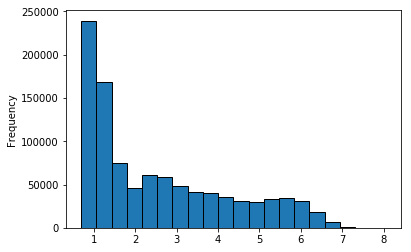

In [43]:
df_raw.freq.plot.hist(edgecolor = 'k', bins=20)

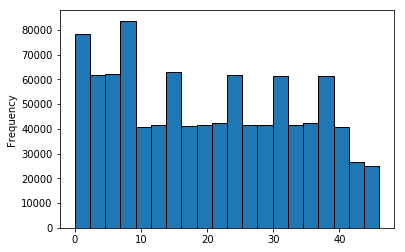

In [44]:
df_raw.distance_closest_holiday.plot.hist(edgecolor = 'k', bins=20)

Text(0,0.5,'Frequency')

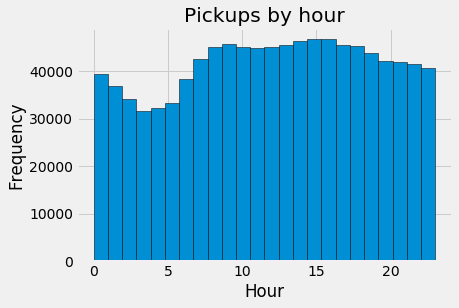

In [45]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.hist(df_raw['pu_hour'], edgecolor = 'k', bins=24)
plt.title('Pickups by hour') 
plt.xlabel('Hour'); plt.ylabel('Frequency')

In [46]:
%%time
import pandas as pd
from pandas.api.types import is_numeric_dtype
df, y, nas = proc_df(df_raw, 'freq')

CPU times: user 724 ms, sys: 615 ms, total: 1.34 s
Wall time: 1.24 s


In [47]:
display_all(df)

,pu_year,pu_month,pu_day,pu_day_of_week,pu_hour,pu_borough,pu_zone,source,days_before_tg,days_before_xm,days_before_md,days_before_fj,days_before_ld,distance_closest_holiday,pu_dtYear,pu_dtMonth,pu_dtWeek,pu_dtDay,pu_dtDayofweek,pu_dtDayofyear,pu_dtIs_month_end,pu_dtIs_month_start,pu_dtIs_quarter_end,pu_dtIs_quarter_start,pu_dtIs_year_end,pu_dtIs_year_start,pu_dtHour,pu_dtMinute,pu_dtSecond,pu_dtElapsed
0,2017,12,31,7,23,2,12,1,-91,-7,-216,-183,-244,7,2017,12,52,31,6,365,True,False,True,False,True,False,23,0,0,1514761200
1,2017,12,31,7,23,2,12,2,-91,-7,-216,-183,-244,7,2017,12,52,31,6,365,True,False,True,False,True,False,23,0,0,1514761200
2,2017,12,31,7,23,2,22,2,-91,-7,-216,-183,-244,7,2017,12,52,31,6,365,True,False,True,False,True,False,23,0,0,1514761200
3,2017,12,31,7,23,2,42,1,-91,-7,-216,-183,-244,7,2017,12,52,31,6,365,True,False,True,False,True,False,23,0,0,1514761200
4,2017,12,31,7,23,2,51,1,-91,-7,-216,-183,-244,7,2017,12,52,31,6,365,True,False,True,False,True,False,23,0,0,1514761200
5,2017,12,31,7,23,2,51,2,-91,-7,-216,-183,-244,7,2017,12,52,31,6,365,True,False,True,False,True,False,23,0,0,1514761200
6,2017,12,31,7,23,2,60,1,-91,-7,-216,-183,-244,7,2017,12,52,31,6,365,True,False,True,False,True,False,23,0,0,1514761200
7,2017,12,31,7,23,2,60,2,-91,-7,-216,-183,-244,7,2017,12,52,31,6,365,True,False,True,False,True,False,23,0,0,1514761200
8,2017,12,31,7,23,2,69,1,-91,-7,-216,-183,-244,7,2017,12,52,31,6,365,True,False,True,False,True,False,23,0,0,1514761200
9,2017,12,31,7,23,2,89,1,-91,-7,-216,-183,-244,7,2017,12,52,31,6,365,True,False,True,False,True,False,23,0,0,1514761200


In [48]:
from sklearn.ensemble import RandomForestRegressor

In [49]:
#def split_vals(a,n): return a[:n].copy(), a[n:].copy()

#n_valid = 10_000
#n_trn = len(df)-n_valid
#raw_train, raw_valid = split_vals(df_raw, n_trn)
#X_train, X_valid = split_vals(df, n_trn)
#y_train, y_valid = split_vals(y, n_trn)

#X_train.shape, y_train.shape, X_valid.shape

In [50]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    return res

In [51]:
#import math
#m = RandomForestRegressor(n_jobs=-1)
#%time m.fit(X_train, y_train)
#print_score(m)

In [52]:
def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.

    Parameters:
    -----------
    df: A pandas data frame, that you wish to sample from.
    n: The number of rows you wish to sample.

    Returns:
    --------
    return value: A random sample of n rows of df.

    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    >>> get_sample(df, 2)
       col1 col2
    1     2    b
    2     3    a
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [53]:
#import numpy as np
#sample_size = 600_000
#df_trn, y_trn, nas = proc_df(df_raw, 'freq', subset=sample_size, na_dict=nas)
#X_train, _ = split_vals(df_trn, int(sample_size*TRAINING_TO_VALIDATION_RATIO))
#y_train, _ = split_vals(y_trn, int(sample_size*TRAINING_TO_VALIDATION_RATIO))

In [54]:
df_raw.corr()['freq'].sort_values()

pu_dtWeek                  -0.007644
pu_dtDayofyear             -0.007101
pu_dtElapsed               -0.006673
pu_month                   -0.006500
pu_dtMonth                 -0.006500
pu_day                     -0.003753
pu_dtDay                   -0.003753
pu_dtIs_year_end           -0.002989
distance_closest_holiday   -0.000727
pu_dtIs_month_end           0.000338
pu_dtIs_month_start         0.000680
pu_dtIs_quarter_start       0.000810
pu_dtIs_quarter_end         0.002584
days_before_md              0.007101
days_before_fj              0.007101
days_before_ld              0.007101
days_before_xm              0.007101
days_before_tg              0.007101
pu_day_of_week              0.015296
pu_dtDayofweek              0.015296
pu_dtHour                   0.085299
pu_hour                     0.085299
freq                        1.000000
pu_year                          NaN
pu_dtYear                        NaN
pu_dtIs_year_start               NaN
pu_dtMinute                      NaN
p

In [55]:
df_raw.drop(['pu_dtHour', 'pu_dtDayofweek', 'pu_dtHour', 'pu_dtDay', 'pu_dtMonth' ], axis=1, inplace=True)

In [56]:
df_raw.corr()['freq'].sort_values()

pu_dtWeek                  -0.007644
pu_dtDayofyear             -0.007101
pu_dtElapsed               -0.006673
pu_month                   -0.006500
pu_day                     -0.003753
pu_dtIs_year_end           -0.002989
distance_closest_holiday   -0.000727
pu_dtIs_month_end           0.000338
pu_dtIs_month_start         0.000680
pu_dtIs_quarter_start       0.000810
pu_dtIs_quarter_end         0.002584
days_before_xm              0.007101
days_before_md              0.007101
days_before_fj              0.007101
days_before_ld              0.007101
days_before_tg              0.007101
pu_day_of_week              0.015296
pu_hour                     0.085299
freq                        1.000000
pu_year                          NaN
pu_dtYear                        NaN
pu_dtIs_year_start               NaN
pu_dtMinute                      NaN
pu_dtSecond                      NaN
Name: freq, dtype: float64

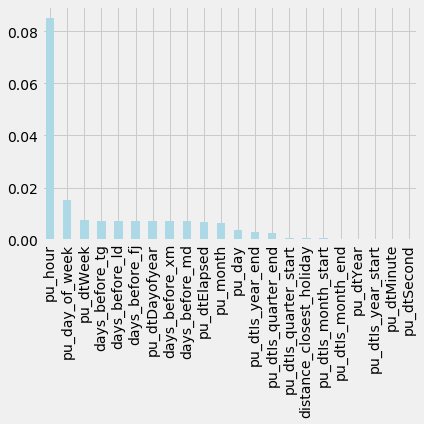

In [57]:
#df_tr = pd.concat([X_train, pd.Series(y_train, name='freq')], axis=1)
#_ = abs(df_tr.corr()['freq']).sort_values(ascending=False).drop(['freq', 'pu_year']).plot.bar(color='lightblue')
_ = abs(df_raw.corr()['freq']).sort_values(ascending=False).drop(['freq', 'pu_year']).plot.bar(color='lightblue')

In [58]:
import numpy as np
df_trn, y_trn, nas = proc_df(df_raw, 'freq', na_dict=nas)
X_train, X_valid, X_test = np.split(df_trn, DATA_RATIOS)
y_train, y_valid, y_test = np.split(y_trn, DATA_RATIOS)

In [59]:
X_train.shape, X_valid.shape, X_test.shape

((800000, 26), (100000, 26), (100000, 26))

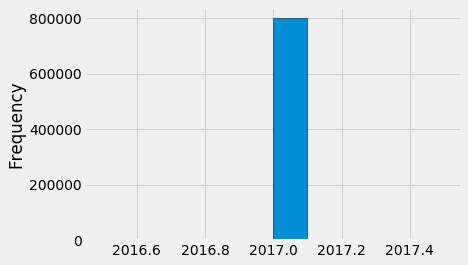

In [60]:
_ = X_train['pu_year'].plot.hist(edgecolor='k')

In [61]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 30s, sys: 789 ms, total: 1min 31s
Wall time: 12 s
[0.134961394449299, 0.3367308262647179, 0.9940753510967011, 0.9632112112345387]


[0.134961394449299, 0.3367308262647179, 0.9940753510967011, 0.9632112112345387]

In [62]:
m = RandomForestRegressor(n_estimators=1, max_depth=4, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.1380263912458226, 1.1384280456462386, 0.5787419892612856, 0.5795049286215388]


[1.1380263912458226,
 1.1384280456462386,
 0.5787419892612856,
 0.5795049286215388]

In [63]:
!pip install msgpack graphviz

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [64]:
from sklearn.tree.export import export_graphviz
import IPython
import graphviz
import re
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.

    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

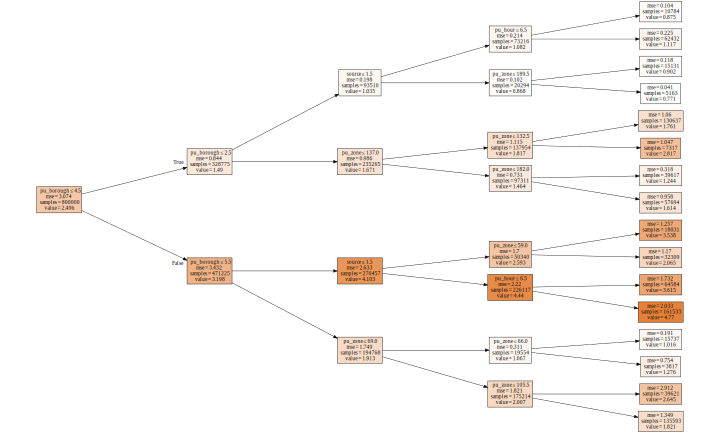

In [65]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [66]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.125224180596694e-16, 0.4559987501406504, 1.0, 0.9325352303387755]


[1.125224180596694e-16, 0.4559987501406504, 1.0, 0.9325352303387755]

# Bagging

In [67]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.13500634385895208, 0.33698138061257427, 0.9940714039854641, 0.9631564433334948]


[0.13500634385895208,
 0.33698138061257427,
 0.9940714039854641,
 0.9631564433334948]

In [68]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([0.69314718, 0.69314718, 0.69314718, 0.69314718, 1.60943791,
        0.69314718, 1.38629436, 0.69314718, 0.69314718, 0.69314718]),
 0.8540909718033554,
 0.6931471805599453)

In [69]:
preds.shape, y_valid.shape

((10, 100000), (100000,))

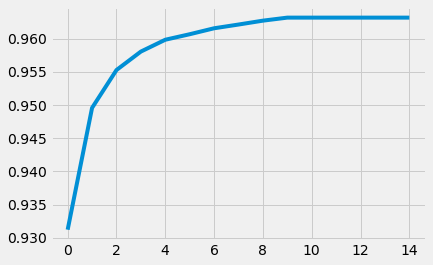

In [70]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn import metrics
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(15)]);

In [71]:
!conda install -y seaborn

Solving environment: done

## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - seaborn


The following packages will be UPDATED:

    certifi:         2018.8.24-py36_1     conda-forge --> 2018.10.15-py36_0
    openssl:         1.0.2p-h470a237_0    conda-forge --> 1.0.2p-h14c3975_0
    seaborn:         0.8.1-py36hfad7ec4_0             --> 0.9.0-py36_0     

The following packages will be DOWNGRADED:

    ca-certificates: 2018.8.24-ha4d7672_0 conda-forge --> 2018.03.07-0     

Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [72]:
%%time
import time
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
def train_trees(params):
    m = RandomForestRegressor(**params)
    started = time.time()
    m.fit(X_train, y_train)
    ended = time.time()
    scores = print_score(m) 
    return [ended-started]+scores

def eval_tree_runs(results, extra_column, oob_score=False):
    results = results
    cols = [extra_column, 'elapsed', 
            'rmse train', 'rmse validation', 
            'score train', 'score validation']
    if oob_score: cols += ['oob score']
    df = pd.DataFrame(results, 
                  columns=cols)
    df.style.bar(subset=['score validation'], color='#d65f5f')
    display_all(df)
    #sns.catplot(x=extra_column,  y="score validation", data=df)
    sns.lineplot(x=extra_column, y="score validation", data=df)
    plt.show()    

CPU times: user 41 ms, sys: 11.7 ms, total: 52.7 ms
Wall time: 1.37 s


In [73]:
#results = [[n]+train_trees({'n_estimators': n, 'n_jobs': -1})for n in [5, 7, 10, 15, 30, 60, 90]]
#eval_tree_runs(results, 'n')

In [74]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11983886357181386, 0.3250549302775877, 0.9953286880620308, 0.9657182287634655, 0.9667312871827544]


[0.11983886357181386,
 0.3250549302775877,
 0.9953286880620308,
 0.9657182287634655,
 0.9667312871827544]

# Subsampling

In [75]:
from sklearn.ensemble import forest
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

In [76]:
def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [77]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


CPU times: user 1min 32s, sys: 518 ms, total: 1min 32s
Wall time: 13.8 s
[0.13496986051498142, 0.3366419833201882, 0.9940746077724316, 0.9632306213561833, 0.9288981638303013]


[0.13496986051498142,
 0.3366419833201882,
 0.9940746077724316,
 0.9632306213561833,
 0.9288981638303013]

[0.30934891081088844, 0.3434754365612848, 0.9688727547232534, 0.9617227167669306]
[0.29321550318729495, 0.3371557859294696, 0.9720348364598403, 0.9631182965671439]
[0.28370575304236095, 0.3318948067631817, 0.9738193882343156, 0.9642603206939747]
[0.27171559814202517, 0.33211226926010307, 0.9759855499191946, 0.964213470993879]
[0.262759499978159, 0.3322170866278298, 0.9775425542697914, 0.9641908783825915]
[0.25503218266398753, 0.33257517427262356, 0.9788440037726257, 0.9641136414479962]


,samples,elapsed,rmse train,rmse validation,score train,score validation
0,75000,2.755215,0.309349,0.343475,0.968873,0.961723
1,100000,3.258812,0.293216,0.337156,0.972035,0.963118
2,120000,3.658262,0.283706,0.331895,0.973819,0.964260
3,150000,4.259328,0.271716,0.332112,0.975986,0.964213
4,175000,4.662694,0.262759,0.332217,0.977543,0.964191
5,200000,5.061877,0.255032,0.332575,0.978844,0.964114


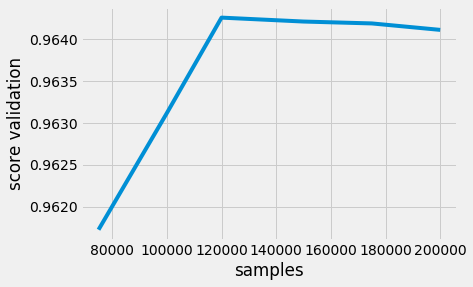

In [78]:

results = []
for no_of_samples in [75_000, 100_000, 120_000, 150_000, 175_000, 200_000]: #[100_000]: #
    set_rf_samples(no_of_samples)
    results += [[no_of_samples]+train_trees({'n_jobs': -1}) ]
eval_tree_runs(results, 'samples')

#results = []
#for no_of_samples in [10_000, 50_000, 100_000, 200_000, 300_000]: #[100_000]: #
#    set_rf_samples(no_of_samples)
#    results += [[no_of_samples]+train_trees({'oob_score': True, 'n_jobs': -1}) ]
#eval_tree_runs(results, 'samples', oob_score=True)

In [79]:
reset_rf_samples()

In [80]:
set_rf_samples(175000)

In [81]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [82]:
%%time
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
_ = print_score(m)

[0.24765676013306612, 0.31638775511635453, 0.9800499549992018, 0.9675220154121927]
CPU times: user 3min 4s, sys: 861 ms, total: 3min 5s
Wall time: 17 s


In [83]:
%%time
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
_ = print_score(m)

[0.24776521971125212, 0.3157171903557372, 0.9800324772023568, 0.9676595397784344, 0.9692617640220201]
CPU times: user 3min 14s, sys: 2.01 s, total: 3min 16s
Wall time: 28.6 s


In [84]:
t=m.estimators_[0].tree_

In [85]:
dectree_max_depth(t)

42

In [86]:
%%time
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.289961526461213, 0.3132448103549954, 0.9726520825636067, 0.9681640725342118, 0.9677384575449004]
CPU times: user 2min 37s, sys: 2.03 s, total: 2min 39s
Wall time: 23.8 s


In [87]:
%%time
t=m.estimators_[0].tree_
print(dectree_max_depth(t))

36
CPU times: user 33.5 ms, sys: 20 µs, total: 33.6 ms
Wall time: 33 ms


In [88]:
%%time
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)
t=m.estimators_[0].tree_
print(dectree_max_depth(t))

[0.27458139664253056, 0.31168136157621495, 0.9754763152444722, 0.9684810746115887, 0.9686289397817393]
38
CPU times: user 2min 48s, sys: 1.86 s, total: 2min 50s
Wall time: 25.3 s


In [89]:
%%time
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=7, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)
t=m.estimators_[0].tree_
print(dectree_max_depth(t))

[0.3000763152645008, 0.31510051767606345, 0.9707108382783194, 0.9677857540083631, 0.9668498179750681]
33
CPU times: user 2min 31s, sys: 1.93 s, total: 2min 33s
Wall time: 23.2 s


[0.2565209833275876, 0.32464421197580146, 0.9785962782028891, 0.9658048064718565]
[0.32307404176571, 0.469607235953267, 0.9660493858292444, 0.928448408581201]


,max features,elapsed,rmse train,rmse validation,score train,score validation
0,1.0,5.275825,0.256521,0.324644,0.978596,0.965805
1,0.5,3.271916,0.323074,0.469607,0.966049,0.928448


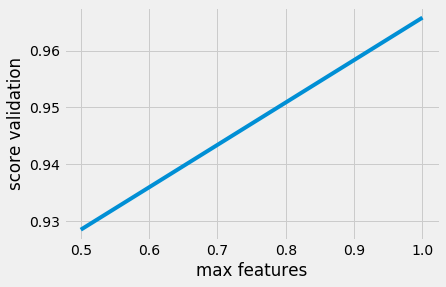

[0.3030469142706291, 0.3185677019925663, 0.9701280731014751, 0.96707291970093]
[0.3143069318290295, 0.32244824511522835, 0.967866988922374, 0.9662658499221018]


,min samples,elapsed,rmse train,rmse validation,score train,score validation
0,7,4.577317,0.303047,0.318568,0.970128,0.967073
1,10,4.478318,0.314307,0.322448,0.967867,0.966266


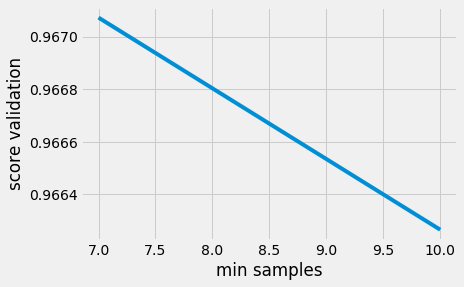

[0.3029965008792273, 0.3180286871515184, 0.9701380109679303, 0.9671842503218678]
[0.41464172127178456, 0.500287277374088, 0.9440771234153873, 0.9187938998088803]


,max features,elapsed,rmse train,rmse validation,score train,score validation
0,1.0,4.573046,0.302997,0.318029,0.970138,0.967184
1,0.5,2.873594,0.414642,0.500287,0.944077,0.918794


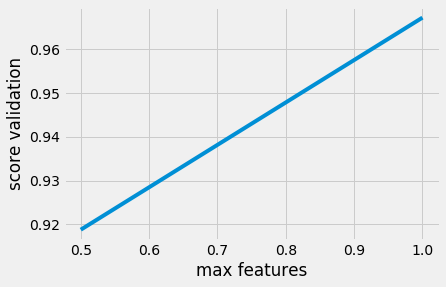

CPU times: user 5min 11s, sys: 5.89 s, total: 5min 17s
Wall time: 45.9 s


In [90]:
%%time
mfs = [1.0, 0.5] #, 0.5, 'log2', 'sqrt']
mss = [7, 10]# [1, 3, 5, 7, 10]

results = \
    [[mf]+
      train_trees(
          {'max_features': mf, 
           'n_estimators': 15, 'n_jobs': -1}) for mf in mfs]

eval_tree_runs(results, 'max features', oob_score=False)

results = \
    [[ms]+
      train_trees(
          {'min_samples_leaf': ms, 
           'n_estimators': 15, 
           'n_jobs': -1}) for ms in mss]

eval_tree_runs(results, 'min samples', oob_score=False)


results = \
    [[mf]+
      train_trees(
          {'max_features': mf, 
           'min_samples_leaf': 7,
           'n_estimators': 15, 'n_jobs': -1}) for mf in mfs]

eval_tree_runs(results, 'max features', oob_score=False)

#r1 = [row[:1]+row[2:] for row in results]
#r2 = [row[1:]    for row in results]
#eval_tree_runs(r1, 'max_features', oob_score=False)
#eval_tree_runs(r2, 'minimum samples', oob_score=False)



In [91]:
#preds = np.stack([t.predict(X_valid) for t in m.estimators_])
#np.mean(preds-y_valid)
print(f"{m}")

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=7, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)


In [92]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def eval_error(label, rf, X, y):
    preds = rf.predict(X)
    #preds = np.stack(np.mean([t.predict(X) for t in rf.estimators_]))
    err = rmse(preds,y)
    print(f"{label}: rmse: {err}")
    
    
def print_score2(m, X_tr, y_tr, X_val, y_val ):
    res = [rmse(m.predict(X_tr), y_tr), 
           rmse(m.predict(X_val), y_val),
           m.score(X_tr, y_tr), 
           m.score(X_val, y_val)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    return res

In [93]:
%%time
rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, max_features=None, oob_score=True, min_samples_leaf=7)
rf = rf.fit(X_train, y_train)
scores = print_score2(rf, X_train, y_train, X_valid, y_valid) 
scores

[0.2996546758615326, 0.31465543251993255, 0.9707930892783011, 0.9678766961395436, 0.9669599136829192]
CPU times: user 3min 18s, sys: 2.2 s, total: 3min 21s
Wall time: 28.7 s


In [94]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_})
fi = rf_feat_importance(rf, X_train)

In [95]:
fi = fi.sort_values('imp', ascending=False); fi

,cols,imp
5,pu_borough,4.753257e-01
6,pu_zone,3.241309e-01
7,source,9.266544e-02
4,pu_hour,8.240576e-02
3,pu_day_of_week,1.491986e-02
25,pu_dtElapsed,2.657289e-03
2,pu_day,2.552157e-03
13,distance_closest_holiday,2.118485e-03
16,pu_dtDayofyear,6.794930e-04
11,days_before_fj,4.445605e-04


In [96]:
display(X_train.head(5))

,pu_year,pu_month,pu_day,pu_day_of_week,pu_hour,pu_borough,pu_zone,source,days_before_tg,days_before_xm,...,pu_dtDayofyear,pu_dtIs_month_end,pu_dtIs_month_start,pu_dtIs_quarter_end,pu_dtIs_quarter_start,pu_dtIs_year_end,pu_dtIs_year_start,pu_dtMinute,pu_dtSecond,pu_dtElapsed
0,2017,12,31,7,23,2,12,1,-91,-7,...,365,True,False,True,False,True,False,0,0,1514761200
1,2017,12,31,7,23,2,12,2,-91,-7,...,365,True,False,True,False,True,False,0,0,1514761200
2,2017,12,31,7,23,2,22,2,-91,-7,...,365,True,False,True,False,True,False,0,0,1514761200
3,2017,12,31,7,23,2,42,1,-91,-7,...,365,True,False,True,False,True,False,0,0,1514761200
4,2017,12,31,7,23,2,51,1,-91,-7,...,365,True,False,True,False,True,False,0,0,1514761200


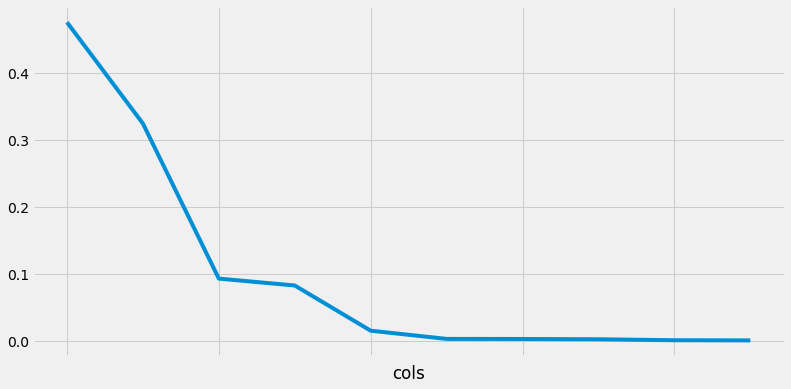

In [97]:
fi[:10].plot('cols', 'imp', figsize=(12,6), legend=False)

In [98]:
keep = fi[fi.imp > .0005]['cols']; keep

5                   pu_borough
6                      pu_zone
7                       source
4                      pu_hour
3               pu_day_of_week
25                pu_dtElapsed
2                       pu_day
13    distance_closest_holiday
16              pu_dtDayofyear
Name: cols, dtype: object

In [99]:
X_train = X_train[keep]
X_valid = X_valid[keep]
X_test = X_test[keep]

In [100]:
%%time
rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, max_features=None, oob_score=True, min_samples_leaf=7)
rf = rf.fit(X_train, y_train)
scores = print_score2(rf, X_train, y_train, X_valid, y_valid) 
scores

[0.29985008822511255, 0.31525855697700456, 0.9707549837329265, 0.9677534316644686, 0.9669196333970723]
CPU times: user 1min 49s, sys: 169 ms, total: 1min 50s
Wall time: 16.5 s


In [101]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)


(800000, 9) (800000,)
(100000, 9) (100000,)
(100000, 9) (100000,)


In [102]:
eval_error('sk train', rf, X_train, y_train)
eval_error('sk valid', rf, X_valid, y_valid)
eval_error('sk test ', rf, X_test, y_test)

sk train: rmse: 0.29985008822511255
sk valid: rmse: 0.31525855697700456
sk test : rmse: 0.3634074116799805


In [103]:
!pip install scipy

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


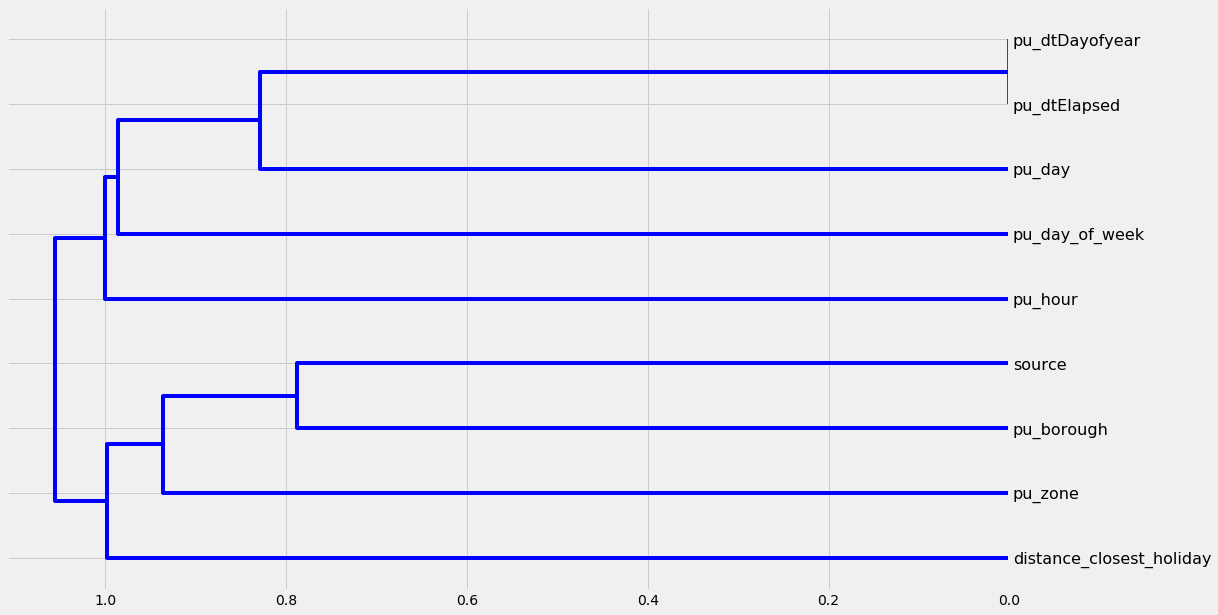

In [104]:
import scipy
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16, 10))
dendrogram = hc.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=16)
plt.show()

In [105]:
!pip install ggplot

    100% |████████████████████████████████| 2.2MB 4.6MB/s ta 0:00:01
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [106]:
_ = X_train.copy()
_['freq'] = y_train.copy()
sample = _.sample(n=500)
#_ = None
print(sample.shape)
display(sample.head(3))

(500, 10)


,pu_borough,pu_zone,source,pu_hour,pu_day_of_week,pu_dtElapsed,pu_day,distance_closest_holiday,pu_dtDayofyear,freq
17767,3,16,2,14,4,1514469600,28,4,362,1.791759
447193,6,55,1,11,6,1507374000,7,6,280,0.693147
796947,5,57,1,9,1,1501491600,31,30,212,4.718499


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


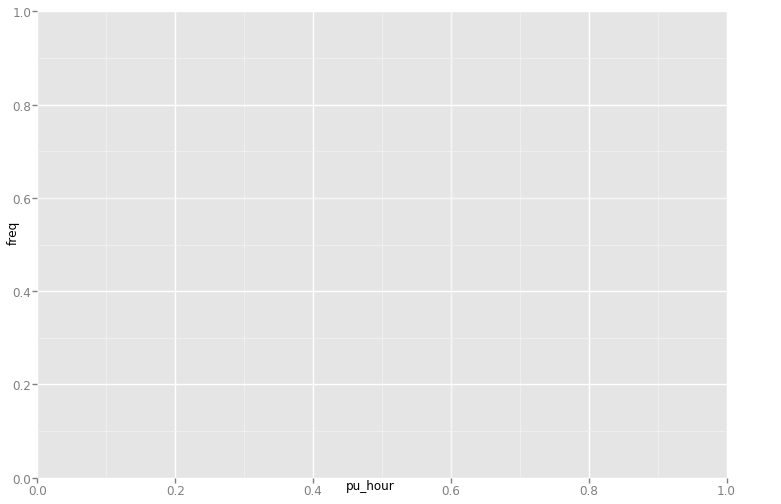

<ggplot: (8736840933829)>

In [107]:
from ggplot import ggplot, aes, stat_smooth
ggplot(sample, aes('pu_hour', 'freq'))#+stat_smooth(se=True) # , method='loess'

In [108]:
!pip install pdp pdpbox

    100% |████████████████████████████████| 57.7MB 877kB/s eta 0:00:01
    100% |████████████████████████████████| 276kB 9.2MB/s eta 0:00:01
  Running setup.py bdist_wheel for pdp ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/84/fb/5e/afb783110614b3c1a4187e6f83e4f4ea0088fbdb82921013a2
  Running setup.py bdist_wheel for pdpbox ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdp pdpbox
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [111]:
#from pdpbox.pdp import pdp_isolate
#import pdp
#import pdpbox
#from pdp import pdpbox.pdp_isolate
def plot_pdp(tree_model, data, feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    
    p = pdp_isolate(tree_model, data, data.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        clusters=clusters is not None, n_cluster_centers=clusters)

In [112]:
#plot_pdp(rf, _, 'pu_hour')

In [113]:
%%time

demarcations = [int(0.8*n), int(0.9*n)]

X_train2, X_valid2, X_test2 = np.split(df_trn.copy(), demarcations)
y_train2, y_valid2, y_test2 = np.split(y_trn.copy(), demarcations)

print(X_train2.shape)
print(y_train2.shape)

rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, max_features=None, oob_score=True, min_samples_leaf=7)
rf = rf.fit(X_train2, y_train2)
scores = print_score2(rf, X_train2, y_train2, X_test2, y_test2) 

(800000, 26)
(800000,)
[0.299680543101276, 0.36291196048674507, 0.9707880465752735, 0.9554292091281685, 0.9669515138527829]
CPU times: user 3min 19s, sys: 2.51 s, total: 3min 21s
Wall time: 28.9 s


In [114]:
eval_error('sk train', rf, X_train2, y_train2)
eval_error('sk test ', rf, X_test2, y_test2)
rmse_sk_test = rmse(rf.predict(X_test2), y_test2)
rmse_sk_test

sk train: rmse: 0.299680543101276
sk test : rmse: 0.36291196048674507


0.362911960486745

In [115]:
X_train2.shape,  X_test2.shape

((800000, 26), (100000, 26))

In [116]:
X_train.columns

Index(['pu_borough', 'pu_zone', 'source', 'pu_hour', 'pu_day_of_week',
       'pu_dtElapsed', 'pu_day', 'distance_closest_holiday', 'pu_dtDayofyear'],
      dtype='object')

Maybe the reason for the max features graph is that we have enough test data to generalize well? Otherwise why is 1.0 better than 0.5?

See below, it turns out not to the the case.

I strongly suspect now that the reason is that I have so few features anyway.

In [117]:
#y_train.shape

In [118]:
#X_train = X_train[-100_000:]
#X_train.shape

In [119]:
#y_train = y_train[-100_000:]
#y_train.shape

In [120]:
def xtrain_trees(params):
    m = RandomForestRegressor(**params)
    started = time.time()
    m.fit(X_train, y_train)
    ended = time.time()
    scores = print_score(m) 
    return [ended-started]+scores

def xeval_tree_runs(results, extra_column, oob_score=False):
    cols = [extra_column, 'elapsed', 
            'rmse train', 'rmse validation', 
            'score train', 'score validation']
    if oob_score: cols += ['oob score']
    df = pd.DataFrame(results, 
                  columns=cols)
    df.style.bar(subset=['score validation'], color='#d65f5f')
    display_all(df)
    sns.catplot(x=extra_column,  y="score validation", data=df)
    
def xprint_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    return res

In [121]:
#results = \
#    [[mf]+
#      train_trees(
#          {'max_features': mf, 
#           'min_samples_leaf': 5,
#           'n_estimators': 15, 'n_jobs': -1}) for mf in mfs]

#eval_tree_runs(results, 'max features', oob_score=False)

In [122]:
bucket = 'mkamp-aws-tmp'
prefix = 'nyc'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer

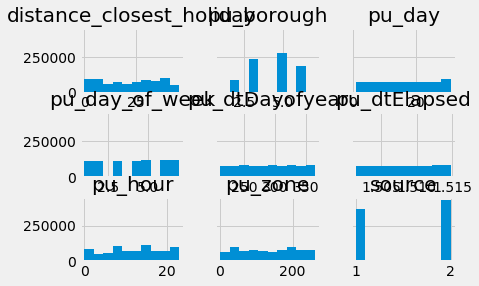

In [124]:
_ = X_train.hist(sharey=True)

In [125]:
# Adding the dependent variable for SM

X_train2['freq'] = y_train2
cols = [X_train2.columns[-1], *X_train2.columns[:-1]]
X_train2 = X_train2[cols]

X_valid2['freq'] = y_valid2
cols = [X_valid2.columns[-1], *X_valid2.columns[:-1]]
X_valid2 = X_valid2[cols]

X_test2['freq'] = y_test2
cols = [X_test2.columns[-1], *X_test2.columns[:-1]]
X_test2 = X_test2[cols]



In [126]:
display_all(X_test2)

,freq,pu_year,pu_month,pu_day,pu_day_of_week,pu_hour,pu_borough,pu_zone,source,days_before_tg,days_before_xm,days_before_md,days_before_fj,days_before_ld,distance_closest_holiday,pu_dtYear,pu_dtWeek,pu_dtDayofyear,pu_dtIs_month_end,pu_dtIs_month_start,pu_dtIs_quarter_end,pu_dtIs_quarter_start,pu_dtIs_year_end,pu_dtIs_year_start,pu_dtMinute,pu_dtSecond,pu_dtElapsed
900000,3.784190,2017,7,11,2,11,6,216,1,82,166,-43,-10,-71,10,2017,28,192,False,False,False,False,False,False,0,0,1499770800
900001,1.386294,2017,7,11,2,11,6,216,2,82,166,-43,-10,-71,10,2017,28,192,False,False,False,False,False,False,0,0,1499770800
900002,1.791759,2017,7,11,2,11,6,217,1,82,166,-43,-10,-71,10,2017,28,192,False,False,False,False,False,False,0,0,1499770800
900003,1.098612,2017,7,11,2,11,6,217,2,82,166,-43,-10,-71,10,2017,28,192,False,False,False,False,False,False,0,0,1499770800
900004,2.302585,2017,7,11,2,11,6,221,1,82,166,-43,-10,-71,10,2017,28,192,False,False,False,False,False,False,0,0,1499770800
900005,1.609438,2017,7,11,2,11,6,229,1,82,166,-43,-10,-71,10,2017,28,192,False,False,False,False,False,False,0,0,1499770800
900006,2.079442,2017,7,11,2,11,6,233,1,82,166,-43,-10,-71,10,2017,28,192,False,False,False,False,False,False,0,0,1499770800
900007,1.609438,2017,7,11,2,11,6,247,1,82,166,-43,-10,-71,10,2017,28,192,False,False,False,False,False,False,0,0,1499770800
900008,0.693147,2017,7,11,2,11,6,247,2,82,166,-43,-10,-71,10,2017,28,192,False,False,False,False,False,False,0,0,1499770800
900009,2.944439,2017,7,11,2,11,6,255,1,82,166,-43,-10,-71,10,2017,28,192,False,False,False,False,False,False,0,0,1499770800


In [127]:
#display_all(X_valid)

In [128]:
X_train2.columns

Index(['freq', 'pu_year', 'pu_month', 'pu_day', 'pu_day_of_week', 'pu_hour',
       'pu_borough', 'pu_zone', 'source', 'days_before_tg', 'days_before_xm',
       'days_before_md', 'days_before_fj', 'days_before_ld',
       'distance_closest_holiday', 'pu_dtYear', 'pu_dtWeek', 'pu_dtDayofyear',
       'pu_dtIs_month_end', 'pu_dtIs_month_start', 'pu_dtIs_quarter_end',
       'pu_dtIs_quarter_start', 'pu_dtIs_year_end', 'pu_dtIs_year_start',
       'pu_dtMinute', 'pu_dtSecond', 'pu_dtElapsed'],
      dtype='object')

In [129]:
_ = X_train2[['pu_borough', 'pu_zone']].groupby(['pu_borough', 'pu_zone']).size().sort_values(ascending=False).head()

for index, item in _.iteritems():
    print('index', index, 'item', item)
display(_)

index (6, 200) item 7402
index (5, 56) item 7400
index (5, 30) item 7399
index (5, 57) item 7397
index (5, 29) item 7389


pu_borough  pu_zone
6           200        7402
5           56         7400
            30         7399
            57         7397
            29         7389
dtype: int64

In [130]:
%%time
import datetime

def rmse(x,y): 
    return np.sqrt(((x-y)**2).mean())

def shift_date(all_data, predict):
    results = []
    for index, row in predict.iterrows():
        year, month, day = int(row['pu_year']), int(row['pu_month']), int(row['pu_day'])
        pu_date = datetime.date(year, month, day)
        ppu_date = pu_date - datetime.timedelta(days=7)
        result = (all_data[(all_data.pu_year == ppu_date.year) & 
                   (all_data.pu_month == ppu_date.month) & 
                   (all_data.pu_day == ppu_date.day) &
                   (all_data.pu_day_of_week == row.pu_day_of_week) & 
                   (all_data.pu_hour == row.pu_hour) &
                   (all_data.pu_borough == row.pu_borough) &
                   (all_data.pu_zone == row.pu_zone) &
                   (all_data.source == row.source)])
        if (len(result) == 0):
            results += [0.0] # math.log(0+1)
        elif (len(result == 1)):
            results += [float(result['freq'])]
        else:
            raise Exception('There can\'t be more than one aggregated pickup record. Check filter criteria.')
        
    return results
#print(X_train.head())
n = 30000
skip = 14 #days


%time predictions = shift_date(X_train2, X_train2[:n]) 
actuals = y_train2[:n]
print(rmse(predictions, actuals))

my_data_selections = ((X_train2.pu_borough==6) & (X_train2.pu_zone==200)) | \
                     ((X_train2.pu_borough==5) & (X_train.pu_zone.isin([56, 30, 57, 29]))) 
my_data = X_train2[my_data_selections]
print(len(my_data))
%time predictions = shift_date(my_data, my_data[:n])
actuals = y_train[my_data_selections][:n]
print(rmse(predictions, actuals))

predictions = rf.predict(my_data[:n].drop(['freq'], axis=1))
print(rmse(predictions, actuals))

# for index, row in df.iterrows():
#   print row['c1'], row['c2']
    
# Compare to exactly one week back
# Just for largest pickup zone?

# Compare to the average of the last 12 month
# Compare to the average for this month from a year back

CPU times: user 5min 24s, sys: 2.47 ms, total: 5min 24s
Wall time: 5min 24s
0.5854241918395072
36987
CPU times: user 2min 32s, sys: 26 ms, total: 2min 32s
Wall time: 2min 32s
0.3635677804532235
0.2501954709389456
CPU times: user 7min 56s, sys: 32.9 ms, total: 7min 56s
Wall time: 7min 56s


In [132]:
!pip install xgboost

    100% |████████████████████████████████| 15.8MB 3.2MB/s eta 0:00:01
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [180]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [181]:
??xgb.XGBRegressor

In [182]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', n_jobs=-1, learning_rate = 0.1, gamma=0.1, alpha = 1, n_estimators = 50)

In [183]:
xg_reg.fit(X_train2.drop('freq', axis=1), y_train2)

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [184]:
predictions = xg_reg.predict(X_test2.copy().drop('freq', axis=1))#.as_matrix()
predictions

array([1.8796712, 2.095233 , 1.8111098, ..., 2.6302662, 2.9779868,
       3.2193408], dtype=float32)

In [185]:
predictions.shape

(100000,)

In [186]:
np.sqrt(np.mean((predictions-y_test2)**2))

1.016903710519061

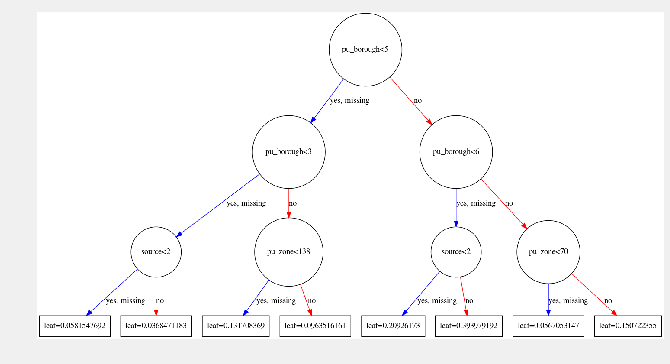

In [191]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [500, 100]
plt.show()

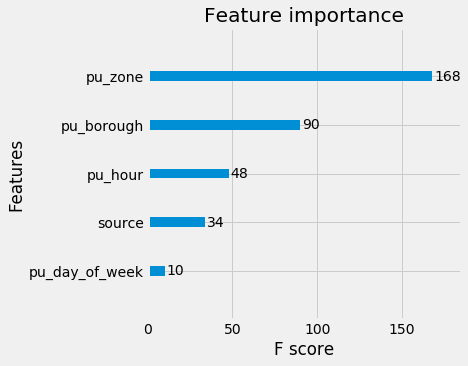

In [190]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [ ]:
...

In [ ]:
#train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
#train_data.to_csv('train.csv', header=False, index=False)
#validation_data.to_csv('validation.csv', header=False, index=False)
X_train2.to_csv('train.csv', header=False, index=False)
X_valid2.to_csv('validation.csv', header=False, index=False)

In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [ ]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [ ]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='reg:linear',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

In [ ]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

In [ ]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

In [ ]:
def predict(data, rows=5000000000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

#predictions = predict(X_valid.drop(['freq'], axis=1).as_matrix())

In [ ]:
#predictions

In [ ]:
#predictions.shape

In [ ]:
predictions = predict(X_test2.copy().drop(['freq'], axis=1).as_matrix())

In [ ]:
predictions

In [ ]:
predictions.shape

In [ ]:
np.sqrt(np.mean((predictions-y_test2)**2))

In [ ]:
#eval_error('sk train', rf2, X_train2, y_train2)
#eval_error('sk test ', rf2, X_test2, y_test2)
rmse_sm_test = rmse(predictions, y_test2)
rmse_sm_test

In [ ]:
math.e**(rmse_sm_test)

In [ ]:
rmse_sk_test

In [ ]:
...

In [ ]:
math.e**(rmse_sk_test)

In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner


In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri

sess = sagemaker.Session()

container = get_image_uri(boto3.Session().region_name, 'xgboost')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eval_metric='rmse',
                        objective='reg:linear',
                        num_round=100,
                        rate_drop=0.3,
                        tweedie_variance_power=1.4)

In [ ]:
hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                        'min_child_weight': ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 2),
                        'max_depth': IntegerParameter(1, 10)}

In [ ]:
tuner = HyperparameterTuner(estimator=xgb,
                            objective_metric_name='validation:rmse',
                            objective_type='Minimize',
                            hyperparameter_ranges = hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3)

In [ ]:
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [ ]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

In [ ]:
tuner.latest_tuning_job.job_name

In [ ]:
container = get_image_uri(boto3.Session().region_name, 'xgboost')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eval_metric='rmse',
                        objective='reg:linear',
                        alpha= 1.9561979663554427,
                        eta=0.30818029283626625,
                        mad_depth=10,
                        num_round=100,
                        min_child_weight= 9.030352864355745)

In [ ]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

In [ ]:
xgb_predictor2 = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

In [ ]:
xgb_predictor2.content_type = 'text/csv'
xgb_predictor2.serializer = csv_serializer

In [ ]:
def predict2(data, rows=5000000000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor2.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [ ]:
predictions = predict2(X_test2.drop(['freq'], axis=1).as_matrix())

In [ ]:
rmse_sm2_test = rmse(predictions, y_test2)
rmse_sm2_test

In [ ]:
[(rmse, math.e**(rmse)) for rmse in [rmse_sk_test, rmse_sm_test, rmse_sm2_test]]

In [ ]:
predictions = predict2(X_valid2.drop(['freq'], axis=1).as_matrix())
rmse(predictions, y_valid2)

# Open

## Does it make sense to scale / logn some of the numerics, e.g. the dependent variable?
Does it make a difference in the score?
Is not doing that the reason that the RMSE is getting so high?

Kind of hard to see what values originally were used for categories.

Try extracting the work day.
Try extracting the "season".

Try to normalize properly, or based on percents, better than ln?

How to change from a small data set to a large data set at night? Specify ratios?

Do_zone, pu_zone still contain null.

Maybe sorting the do_zone and pu_zone would help, so that they are sorted by their parent?

How do we install libraries? conda? pip? How to do it again in every notebook?

Hard to see if the Notebook is still working? Refresh brings it in an unknown state showing nothing is running, but the asterisks doesn't work anymore.

Kaggle walk through would be nice.